# Imports 

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from SIRD_initialization import Grid
from SIRD_initialization import Location
from matplotlib.font_manager import FontProperties



# Basic SIRD Model

In [ ]:
# Define the SIRD model differential equations.
def sird_model(y, t, beta, gamma, delta):
    S, I, R, D = y
    dSdt = -beta * S * I
    dIdt = beta * S * I - gamma * I - delta * I
    dRdt = gamma * I
    dDdt = delta * I
    return [dSdt, dIdt, dRdt, dDdt]

# Set the initial conditions and parameters.
initial_conditions = [0.99, 0.01, 0, 0]  # S, I, R, D
beta = 0.3  # Infection rate
gamma = 0.1  # Recovery rate
delta = 0.01  # Death rate

# Set the time points for the simulation.
t = np.linspace(0, 200, 1000)

# Solve the ODEs using odeint.
solution = odeint(sird_model, initial_conditions, t, args=(beta, gamma, delta))

# Extract the results.
S, I, R, D = solution.T

# Plot the results.
plt.plot(t, S, label='Susceptible')
plt.plot(t, I, label='Infected')
plt.plot(t, R, label='Recovered')
plt.plot(t, D, label='Deceased')
plt.xlabel('Time')
plt.ylabel('Proportion of Population')
plt.title('Basic SIRD Model')
plt.legend()
plt.show()


## Mobility Based SIRD Model - Random, High, Low

In [2]:
def calculate_averages(final_results, days, index):
    num_columns = days
    columns_sums = [0] * num_columns
    num_items = 0
    for key in final_results:
        sird = final_results[key][index]
        columns_sums = [columns_sums[i] + sird[i] for i in range(num_columns)]
        num_items += 1
    
    average_sird = [sum_column / num_items for sum_column in columns_sums]
    return average_sird

        

In [3]:
def get_other_loc_params(grid,loc):
    infections = 0
    total_connections = 0
    for j in loc.connections:
        if grid.map[j].n != 0:
            infections += loc.connections[j] * (grid.map[j].i / grid.map[j].n)
            total_connections += loc.connections[j]
    
    return infections, total_connections

In [7]:
def dynamic_alpha(type, threshold, beta, mu, N, n_locations, days, alpha_range, trials, delta_c, delta_g, birth_rate):
    alpha_sir = {}
    for alpha in alpha_range:
        final_results = {}
        for trial in range(trials):
    
            # Initialize grid and locations
            grid = Grid(n_locations, N, alpha, beta, mu)

            # Initialize random starting location based on chosen Mobility Type
            if type == "Random":
                grid.random_orgin()
            elif type == "High":
                grid.mobility_based_origin(threshold, True)
            else:
                grid.mobility_based_origin(threshold, False)

            susceptible = np.zeros(days)
            infectious = np.zeros(days)
            recovered = np.zeros(days) 
            dead = np.zeros(days)

            for day in range(days):
                for loc in grid.map:
                    if loc.n != 0:
                        infections, total_connections = get_other_loc_params(grid, loc)

                        # find new infections
                        new_infections = (beta * loc.s * loc.i/ loc.n) + ((alpha*loc.s*infections*beta)/(loc.n+total_connections))
                    
                        # determine number of deaths
                        infection_deaths = delta_c * loc.i
                        general_deaths_s = delta_g * loc.s
                        general_deaths_r = delta_g * loc.r
                        
                        # determine new recoveries
                        new_recoveries = (mu * loc.i)
                        new_births = birth_rate * (loc.s + loc.i + loc.r)
                        
                        # update categories
                        loc.i += new_infections
                        loc.s -= new_infections
                        
                        loc.i -= infection_deaths

                        loc.d += infection_deaths
                        
                        loc.s -= general_deaths_s
                        loc.d += general_deaths_s + general_deaths_r
                        loc.r -= general_deaths_r

                        loc.i -=  new_recoveries                        
                        loc.r += new_recoveries
                        loc.s += new_births


                        loc.n = loc.s + loc.i + loc.r + loc.d

                        susceptible[day] = loc.s/loc.n
                        infectious[day] = loc.i/loc.n
                        recovered[day] = loc.r/loc.n
                        dead[day] = loc.d/loc.n

            
            
            final_results[str(trial)] = [susceptible, infectious, recovered, dead]

        susceptible = calculate_averages(final_results, days, 0)
        infectious = calculate_averages(final_results, days, 1)
        recovered = calculate_averages(final_results, days, 2)
        dead = calculate_averages(final_results, days, 3)
        alpha_sir[alpha] = [susceptible, infectious, recovered, dead]
    return alpha_sir




In [5]:
import matplotlib.pyplot as plt
import numpy as np
def sir_plotting(results, type):
    translation = {0: "S", 1: "I", 2: "R", 3: "D"}

    # Calculate the number of rows and columns based on the number of results
    num_rows = len(results) // 2 + len(results) % 2
    num_cols = 2


    # Set the figure size
    plt.figure(figsize=(15, 5 * num_rows))

    for idx, (key, values) in enumerate(results.items()):
        # Create subplots
        plt.subplot(num_rows, num_cols, idx + 1)

        for sublist in values:
            plt.plot(sublist, label=translation[values.index(sublist)], linewidth=5)
            if type != "Random" and type != "High":
                type = "Low"
            font_bold = FontProperties(weight="bold")
            plt.title(f'SIRD Model w/ {type} Mobility: Alpha = {round(key,1)}', fontproperties=font_bold)

        plt.legend()
        plt.xlabel("Time (Days)", fontproperties=font_bold)
        plt.ylabel("Population Density", fontproperties=font_bold)

    # Adjust layout to prevent overlapping
    plt.tight_layout()
    plt.show()

In [20]:
beta = 0.3              # rate of infection *CHANGE LATER MAYBE*
mu = 0.1                # rate of recovery *CHANGE LATER MAYBE*
delta_c = 0.004         # rate of death from COVID worldwide
delta_g = 0.009       # general death rate worldwide
birth_rate = 0.019    # population growth is ~1% worldwide so set birth rate as 1% higher than general death rate
N = 1000000
n_locations=50
days = 200
alphas = [0.1,0.2,0.4,0.6,0.8,1.0]
trials = 10


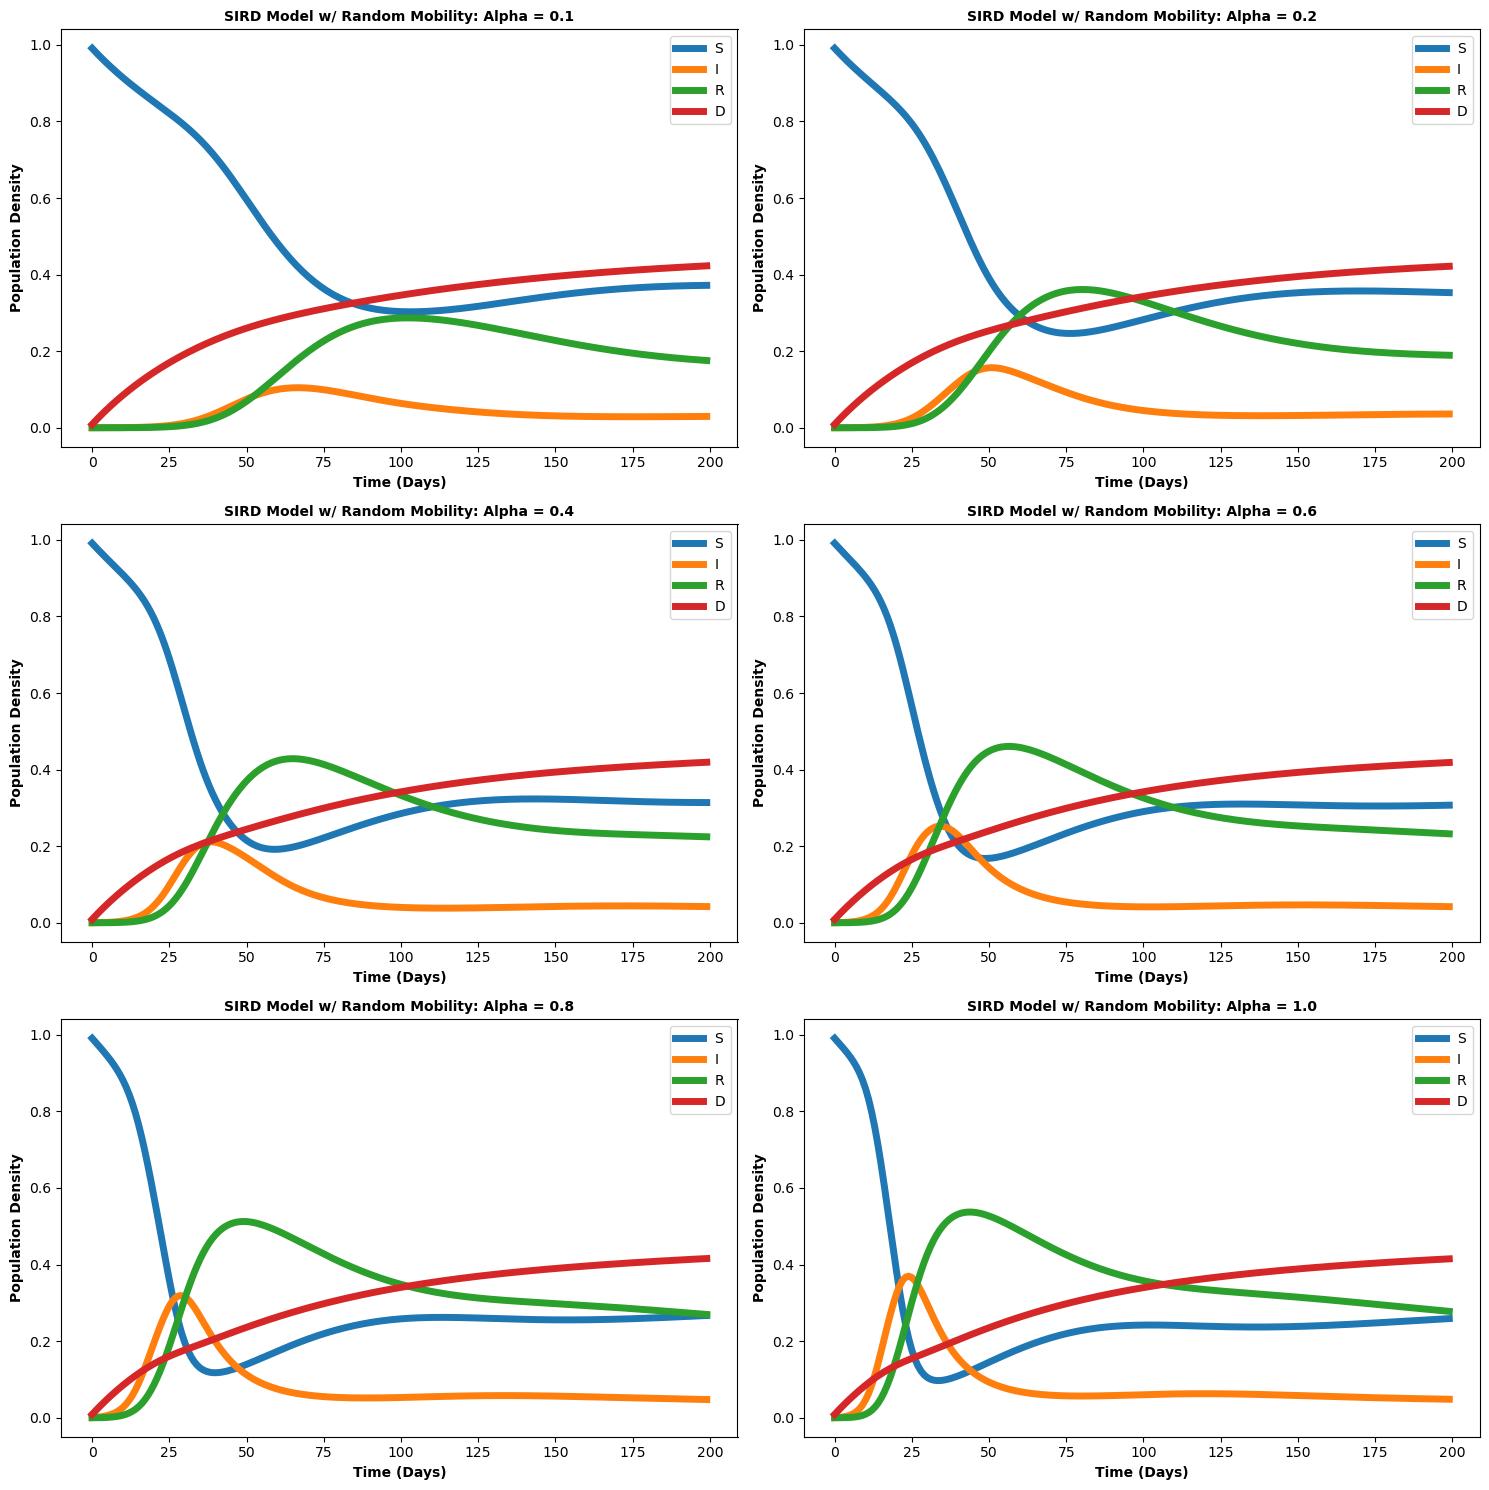

In [21]:
type = "Random"
threshold = 0.1
dynamic_alpha_results = dynamic_alpha(type, threshold, beta, mu, N, n_locations, days, alphas, trials, delta_c, delta_g, birth_rate)
sir_plotting(dynamic_alpha_results, type)

In [ ]:
type = "High"
threshold = 0.1
dynamic_alpha_results = dynamic_alpha(type, threshold, beta, mu, N, n_locations, days, alphas, trials, delta_c, delta_g, birth_rate)
sir_plotting(dynamic_alpha_results, type)


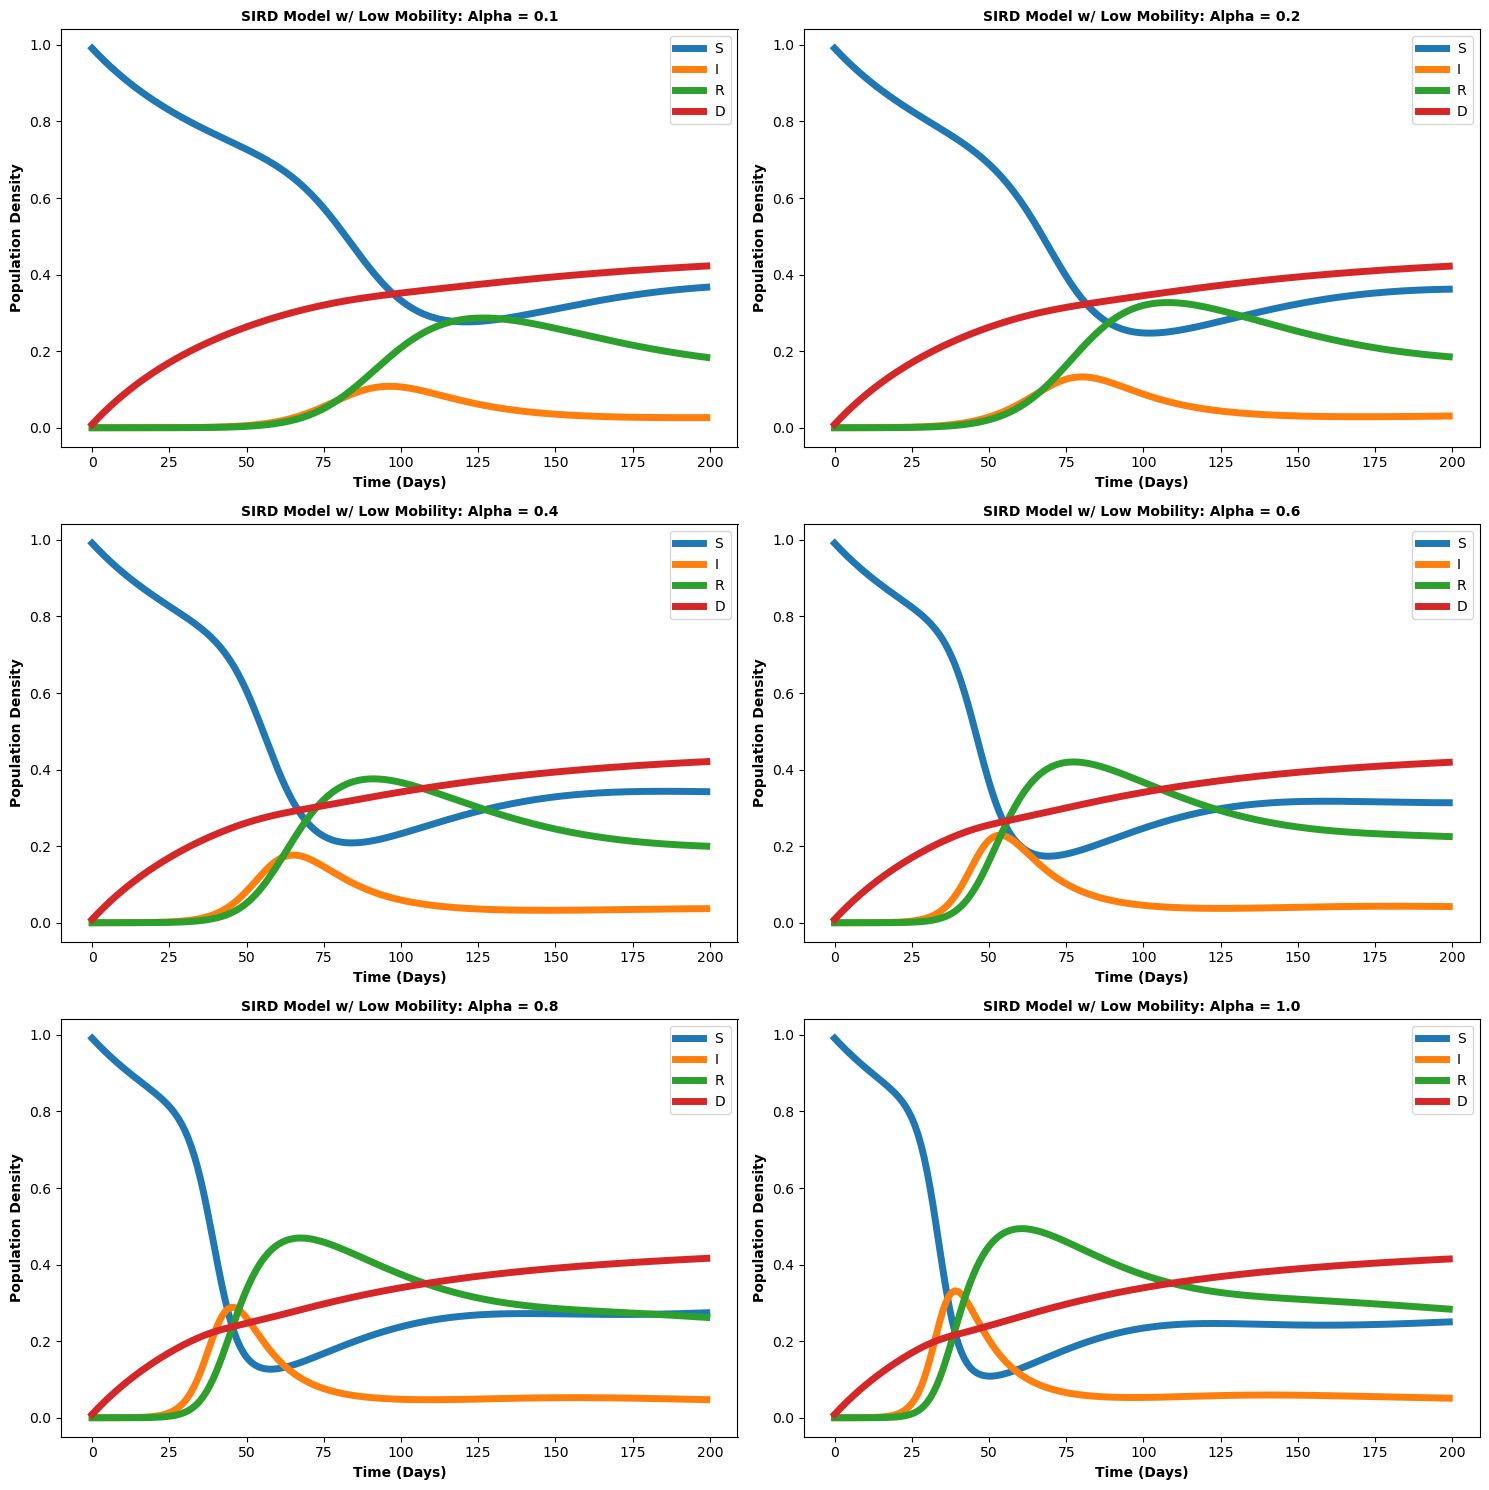

In [22]:
type = "Low"
threshold = 0.1
dynamic_alpha_results = dynamic_alpha(type, threshold, beta, mu, N, n_locations, days, alphas, trials, delta_c, delta_g, birth_rate)
sir_plotting(dynamic_alpha_results, type)

In [44]:
def dynamic_alpha_connectivity(beta, mu, N, n_locations, days, alpha_range, trials, delta_c, delta_g, birth_rate, outside_connectivity):

    alpha_connectivity_sir = {}
    for alpha in alpha_range:
        for c in outside_connectivity:
            for trial in range(trials):
                alpha_connectivity_sir[(alpha,c)] = []
                # Create arrays to store the results
                infectious = np.zeros(days)
                #Initialize grid and locations
                grid = Grid(n_locations, N, alpha, beta, mu)
                grid.random_orgin()

                grid.edit_connections(c)

                day = 0
                for day in range(days):
                    for loc in grid.map:
                        if loc.n != 0:
                            infections, total_connections = get_other_loc_params(grid, loc)

                            # find new infections
                            new_infections = (beta * loc.s * loc.i/ loc.n) + ((alpha*loc.s*infections*beta)/(loc.n+total_connections))
                        
                            # determine number of deaths and remove from population
                            infection_deaths = delta_c * loc.i
                            general_deaths_s = delta_g * loc.s
                            general_deaths_r = delta_g * loc.r
                            # determine new recoveris
                            new_recoveries = (mu * loc.i)

                            new_births = birth_rate *loc.s

                            loc.i += new_infections

                            loc.s -= new_infections
                            
                            loc.i -= infection_deaths

                            loc.d += infection_deaths
                            
                            loc.s -= general_deaths_s
                            loc.d += general_deaths_s + general_deaths_r
                            loc.r -= general_deaths_r

                            loc.i -=  new_recoveries                        
                            loc.r += new_recoveries
                            loc.s += new_births

                            loc.n = loc.s + loc.i + loc.r + loc.d

                            infectious[day] = loc.i/loc.n
                    #if infectious[day] < infectious[day-1] and day > 0:
                       # alpha_connectivity_sir[(alpha,c)].append(day-1)
                       # break
                alpha_connectivity_sir[(alpha,c)].append(np.argmax(infectious))
                #if len(alpha_connectivity_sir[(alpha,c)]) == 0:
                   # alpha_connectivity_sir[(alpha,c)].append(day)

            alpha_connectivity_sir[(alpha,c)] = np.mean(alpha_connectivity_sir[(alpha,c)])

    return list(alpha_connectivity_sir.values())
    

In [53]:
def plotting_dynamic_alpha_connectivity(alpha_range, outside_connectivity, max_infections):
    x, y = np.meshgrid(alpha_range, outside_connectivity[::-1])
    font_bold = FontProperties(weight="bold")

    z = []
    for i in range(len(outside_connectivity)):
        miniList = []
        for j in range(len(alpha_range)):
            miniList.append(max_infections.pop(0))
        z.append(miniList)
    z = np.array(z)

    fig = plt.figure(figsize = (18, 20))
    ax = fig.add_subplot(111, projection='3d')
    surface = ax.plot_surface(x, y, z, cmap='viridis')
    fig.colorbar(surface, ax=ax, shrink=0.5, aspect=10)

    ax.set_xlabel('Social Connectivity Alpha', fontproperties=font_bold)
    ax.set_ylabel('Outside Connectivity', fontproperties=font_bold)
    ax.set_zlabel('Max Infections', fontproperties=font_bold)
    ax.set_title('Combining Alpha and Outside Connectivity', fontproperties=font_bold, fontsize=25)

    plt.show()

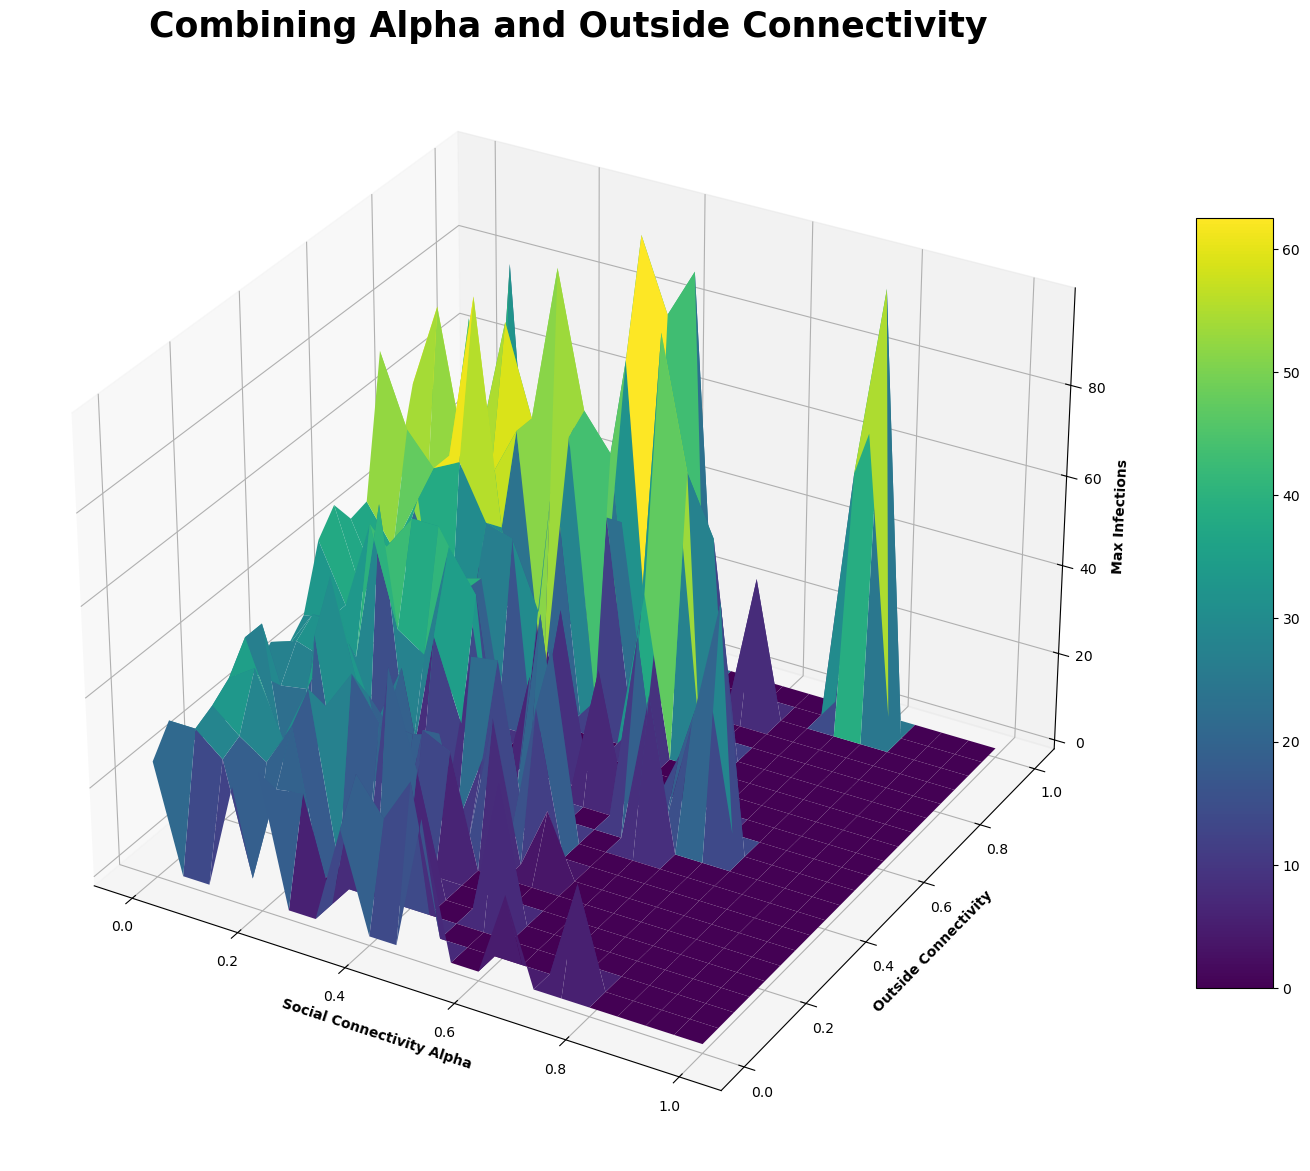

In [54]:
beta = 0.3 # rate of infection *CHANGE LATER MAYBE*
mu = 0.1 # rate of recovery *CHANGE LATER MAYBE*
delta_c = 0.004 # rate of death from COVID for Estonia
delta_g = 0.014 # general death rate in Estonia
birth_rate = 0.009
N = 100000
n_locations=50
days = 100
alphas = np.arange(0,1.05,0.05)
outside_connectivity = np.arange(0,1.05,0.05)
trials=5
type = "Random"
threshold = 0.1

max_infections = dynamic_alpha_connectivity(beta, mu, N, n_locations, days, alphas, trials, delta_c, delta_g, birth_rate, outside_connectivity)
plotting_dynamic_alpha_connectivity(alphas, outside_connectivity, max_infections)